In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

###  **Stock Market Prediction with Sentiment Analysis** 

Unlock the power of **machine learning** and **sentiment analysis** to predict stock market trends in this engaging and insightful notebook! In this project, we combine **LSTM networks** with sentiment scores from **real-world news headlines** to forecast stock prices for **configurable stocks**.

🎯 **Configurable Stock Analysis**: This notebook is designed to analyze any stock symbol by simply changing the `STOCK_SYMBOL` variable. Switch between AAPL, TSLA, MSFT, GOOGL, or any other supported stock!

 **What's inside?**
- **Data Collection & Preprocessing**: Learn how to fetch real-time stock data from **Yahoo Finance** for a hands-on experience.
- **Sentiment Analysis**: We dive into **advanced sentiment analysis** to extract sentiment from news headlines and uncover how **sentiment** influences stock prices.
- **LSTM Models for Time-Series Forecasting**: See how **Long Short-Term Memory (LSTM)** networks can predict stock price movements based on historical trends.
- **Interactive Visualizations**: Explore clear, insightful plots that compare **actual vs. predicted stock prices**, display **sentiment distributions**, and show how the model performs over time.
- **Comprehensive Evaluation**: Understand how **sentiment** can be integrated as a powerful feature in forecasting stock prices, and evaluate the accuracy of the model.

 **Perfect for**:
- **Data Scientists** eager to apply **natural language processing** and **deep learning** to real-world financial problems.
- **Finance Professionals** looking to see how sentiment can shape stock price predictions.
- **Machine Learning Enthusiasts** excited about **time-series forecasting** and **sentiment-driven models**.

---

####  **Join the Journey!**
Explore the fascinating intersection of **finance** and **AI**. Let's see how we can **enhance stock predictions** with **sentiment analysis** and machine learning. Get ready to **boost your data science skills** and gain a deeper understanding of stock market behavior!

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print(" Random seeds set to 42 for reproducibility")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

 Random seeds set to 42 for reproducibility


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jayden\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [95]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Do not pass an `input_shape`")


In [96]:
# =============================================================================
#  CONFIGURATION - CHANGE THESE PARAMETERS AS NEEDED
# =============================================================================

# CONFIGURE YOUR STOCK HERE - CHANGE THIS TO ANY STOCK SYMBOL
STOCK_SYMBOL = "TSLA"  # Change this to: "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", etc.

# Available stocks in the sentiment dataset:
# "AAPL", "AMZN", "AVGO", "COST", "GOOG", "JNJ", "JPM", "LLY", 
# "MA", "META", "MSFT", "NFLX", "NVDA", "ORCL", "PG", "TSLA", "V", "WMT", "XOM"

# Date range for analysis
START_DATE = "2021-06-20"
END_DATE = "2025-06-20"

# Model configuration
TIME_STEPS = 60
TEST_SIZE = 0.2  # 20% for test set
RANDOM_SEED = 42

# Hyperparameter tuning configuration
N_TRIALS = 10  # Number of Optuna trials - adjust this easily
N_CV_FOLDS = 3  # Number of cross-validation folds

print(f"STOCK ANALYSIS CONFIGURATION")
print(f"Target Stock: {STOCK_SYMBOL}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Time Steps: {TIME_STEPS}")
print(f"Test Size: {TEST_SIZE*100:.0f}%")
print(f"Optuna Trials: {N_TRIALS}")
print(f"CV Folds: {N_CV_FOLDS}")
print(f"Random Seed: {RANDOM_SEED}")
print(f"To analyze a different stock, change STOCK_SYMBOL above and re-run all cells")
print(f"=" * 60)

STOCK ANALYSIS CONFIGURATION
Target Stock: TSLA
Date Range: 2021-06-20 to 2025-06-20
Time Steps: 60
Test Size: 20%
Optuna Trials: 10
CV Folds: 3
Random Seed: 42
To analyze a different stock, change STOCK_SYMBOL above and re-run all cells


In [97]:
# =============================================================================
#  DIRECT IMPORT OF PREPROCESSED STOCK PRICE + SENTIMENT DATA
# =============================================================================

print(" IMPORTING PREPROCESSED STOCK PRICE + SENTIMENT DATA")
print("=" * 60)

# Import the preprocessed combined dataset
try:
    stock_data = pd.read_csv('stock_price_with_sentiment.csv')
    print(f" Successfully loaded combined dataset: {stock_data.shape}")
    
    # Convert Date column to datetime
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    
    # Display dataset info
    print(f" Date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
    print(f" Available tickers: {sorted(stock_data['ticker'].unique())}")
    print(f" Total records: {len(stock_data):,}")
    
    # Display available columns
    print(f"\n Available columns ({len(stock_data.columns)}):")
    for i, col in enumerate(stock_data.columns, 1):
        print(f"   {i:2d}. {col}")
    
    # Check data types
    print(f"\n Data types:")
    print(stock_data.dtypes)
    
    # Filter for the configured stock
    print(f"\n Filtering data for: {STOCK_SYMBOL}")
    
    if STOCK_SYMBOL in stock_data['ticker'].unique():
        stock_data = stock_data[stock_data['ticker'] == STOCK_SYMBOL].copy()
        stock_data = stock_data.sort_values('Date').reset_index(drop=True)
        
        print(f" Successfully filtered for {STOCK_SYMBOL}")
        print(f" Records for {STOCK_SYMBOL}: {len(stock_data):,}")
        print(f" Date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
        
        # Display sample data
        print(f"\n Sample data for {STOCK_SYMBOL}:")
        sample_cols = ['Date', 'Close', 'avg_sentiment_score', 'sentiment_lag', 'sentiment_7d_avg']
        available_sample_cols = [col for col in sample_cols if col in stock_data.columns]
        print(stock_data[available_sample_cols].head(10).to_string(index=False))
        
    else:
        print(f" ERROR: {STOCK_SYMBOL} not found in dataset!")
        print(f"Available tickers: {sorted(stock_data['ticker'].unique())}")
        raise ValueError(f"Stock {STOCK_SYMBOL} not available in dataset")
    
except FileNotFoundError:
    print(" ERROR: stock_price_with_sentiment.csv not found!")
    print(" Please run create_stock_price_with_sentiment.ipynb first to generate the combined dataset.")
    raise

print(f"\n DATASET READY FOR {STOCK_SYMBOL}")
print(f" Data loaded and filtered successfully")
print(f" Shape: {stock_data.shape}")
print(f" Ready for model training!")

 IMPORTING PREPROCESSED STOCK PRICE + SENTIMENT DATA
 Successfully loaded combined dataset: (20330, 26)
 Date range: 2021-05-21 00:00:00 to 2025-06-20 00:00:00
 Available tickers: ['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']
 Total records: 20,330

 Available columns (26):
    1. ticker
    2. Date
    3. Open
    4. High
    5. Low
    6. Close
    7. Volume
    8. MA_3
    9. MA_7
   10. MA_10
   11. RSI
   12. MACD
   13. daily_sentiment_score
   14. sentiment_3d_avg
   15. sentiment_7d_avg
   16. sentiment_10d_avg
   17. sentiment_lag_1d
   18. sentiment_lag_3d
   19. sentiment_std
   20. sentiment_volatility_3d
   21. sentiment_volatility_7d
   22. news_volume
   23. news_volume_3d_avg
   24. news_volume_7d_avg
   25. daily_sentiment_category
   26. stock_id

 Data types:
ticker                              object
Date                        datetime64[ns]
Open                 

In [98]:
# =============================================================================
#  FEATURE ANALYSIS AND BASELINE MODEL TRAINING
# =============================================================================

print("FEATURE ANALYSIS AND BASELINE MODEL TRAINING")
print("=" * 60)

# Reset random seeds for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Create helper function for sequence creation
def create_sequences(data, features_list, target_col='Close', time_steps=TIME_STEPS):
    """Create sequences for LSTM training"""
    X, y = [], []
    
    for i in range(time_steps, len(data)-1):
        feature_sequence = data[features_list].iloc[i-time_steps:i].values
        target_value = data[target_col].iloc[i+1]
        
        if feature_sequence.shape[0] == time_steps and feature_sequence.shape[1] == len(features_list):
            if not np.isnan(feature_sequence).any() and not np.isnan(target_value):
                X.append(feature_sequence)
                y.append(target_value)
    
    return np.array(X), np.array(y)

# Create helper function for model evaluation
def evaluate_model(model, X_test, y_test, y_scaler, model_name):
    """Evaluate model and return metrics"""
    pred_scaled = model.predict(X_test, verbose=0)
    predictions = y_scaler.inverse_transform(pred_scaled).flatten()
    actual = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    rmse = math.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return {
        'model_name': model_name,
        'predictions': predictions,
        'actual': actual,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

# =============================================================================
# IDENTIFY BEST SENTIMENT FEATURE
# =============================================================================

print("\nIdentifying best sentiment feature...")
base_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Test different sentiment features
sentiment_features = ['sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg']
sentiment_results = {}

for sentiment_feature in sentiment_features:
    if sentiment_feature in stock_data.columns:
        print(f"Testing {sentiment_feature}...")
        
        # Create sequences with sentiment feature
        features_with_sentiment = base_features + [sentiment_feature]
        X_sent, y_sent = create_sequences(stock_data, features_with_sentiment)
        
        # Use consistent train/test split
        n_samples = len(X_sent)
        test_size = int(TEST_SIZE * n_samples)
        train_size = n_samples - test_size
        
        X_train = X_sent[:train_size]
        X_test = X_sent[train_size:]
        y_train = y_sent[:train_size]
        y_test = y_sent[train_size:]
        
        # Scale data
        X_train_scaled = np.zeros_like(X_train)
        X_test_scaled = np.zeros_like(X_test)
        
        # Fit scaler on training data
        train_flat = X_train.reshape(-1, len(features_with_sentiment))
        scaler = MinMaxScaler()
        scaler.fit(train_flat[:, :5])  # Only fit on price features
        
        # Apply scaling
        for i in range(len(X_train)):
            X_train_scaled[i, :, :5] = scaler.transform(X_train[i, :, :5])
            X_train_scaled[i, :, 5:] = X_train[i, :, 5:]
        
        for i in range(len(X_test)):
            X_test_scaled[i, :, :5] = scaler.transform(X_test[i, :, :5])
            X_test_scaled[i, :, 5:] = X_test[i, :, 5:]
        
        # Scale targets
        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
        
        # Train simple model for comparison
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, len(features_with_sentiment))),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0)
        
        # Evaluate
        results = evaluate_model(model, X_test_scaled, y_test_scaled, y_scaler, sentiment_feature)
        sentiment_results[sentiment_feature] = results
        
        print(f"  {sentiment_feature}: RMSE ${results['rmse']:.2f}")

# Find best sentiment feature
best_sentiment_feature = min(sentiment_results.keys(), key=lambda x: sentiment_results[x]['rmse'])
print(f"\nBest sentiment feature: {best_sentiment_feature}")
print(f"RMSE: ${sentiment_results[best_sentiment_feature]['rmse']:.2f}")

# =============================================================================
# PREPARE FINAL DATASETS FOR COMPARISON
# =============================================================================

print(f"\nPreparing final datasets for comparison...")

# Dataset 1: OCHLV only (baseline)
baseline_features = base_features
X_baseline, y_baseline = create_sequences(stock_data, baseline_features)

# Dataset 2: OCHLV + best sentiment
best_features = base_features + [best_sentiment_feature]
X_best, y_best = create_sequences(stock_data, best_features)

# Use consistent train/test split for both
n_samples = len(X_best)
test_size = int(TEST_SIZE * n_samples)
train_size = n_samples - test_size

# Split datasets
X_baseline_train = X_baseline[:train_size]
X_baseline_test = X_baseline[train_size:]
y_baseline_train = y_baseline[:train_size]
y_baseline_test = y_baseline[train_size:]

X_best_train = X_best[:train_size]
X_best_test = X_best[train_size:]
y_best_train = y_best[:train_size]
y_best_test = y_best[train_size:]

print(f"Training samples: {train_size}")
print(f"Test samples: {test_size}")
print(f"Baseline features: {baseline_features}")
print(f"Best features: {best_features}")

# Store for later use
globals().update({
    'baseline_features': baseline_features,
    'best_features': best_features,
    'best_sentiment_feature': best_sentiment_feature,
    'X_baseline_train': X_baseline_train,
    'X_baseline_test': X_baseline_test,
    'y_baseline_train': y_baseline_train,
    'y_baseline_test': y_baseline_test,
    'X_best_train': X_best_train,
    'X_best_test': X_best_test,
    'y_best_train': y_best_train,
    'y_best_test': y_best_test
})

FEATURE ANALYSIS AND BASELINE MODEL TRAINING

Identifying best sentiment feature...
Testing sentiment_3d_avg...
  sentiment_3d_avg: RMSE $28.04
Testing sentiment_7d_avg...
  sentiment_7d_avg: RMSE $25.90
Testing sentiment_10d_avg...
  sentiment_10d_avg: RMSE $30.00

Best sentiment feature: sentiment_7d_avg
RMSE: $25.90

Preparing final datasets for comparison...
Training samples: 764
Test samples: 190
Baseline features: ['Open', 'High', 'Low', 'Close', 'Volume']
Best features: ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_7d_avg']


In [99]:
# =============================================================================
# BASELINE MODEL TRAINING
# =============================================================================

print("BASELINE MODEL TRAINING")
print("=" * 60)

# Reset random seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# =============================================================================
# SCALE DATA FOR BASELINE MODEL
# =============================================================================

print("Scaling data for baseline model...")

# Scale baseline features
X_baseline_train_scaled = np.zeros_like(X_baseline_train)
X_baseline_test_scaled = np.zeros_like(X_baseline_test)

# Fit scaler on training data
train_flat = X_baseline_train.reshape(-1, len(baseline_features))
baseline_scaler = MinMaxScaler()
baseline_scaler.fit(train_flat)

# Apply scaling
for i in range(len(X_baseline_train)):
    X_baseline_train_scaled[i] = baseline_scaler.transform(X_baseline_train[i])
for i in range(len(X_baseline_test)):
    X_baseline_test_scaled[i] = baseline_scaler.transform(X_baseline_test[i])

# Scale targets
baseline_y_scaler = MinMaxScaler()
y_baseline_train_scaled = baseline_y_scaler.fit_transform(y_baseline_train.reshape(-1, 1)).flatten()
y_baseline_test_scaled = baseline_y_scaler.transform(y_baseline_test.reshape(-1, 1)).flatten()

# =============================================================================
# TRAIN BASELINE MODEL
# =============================================================================

print("Training baseline OCHLV model...")

# Build baseline model
baseline_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, len(baseline_features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

baseline_model.compile(optimizer='adam', loss='mean_squared_error')

# Train baseline model
baseline_history = baseline_model.fit(
    X_baseline_train_scaled, y_baseline_train_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_baseline_test_scaled, y_baseline_test_scaled),
    verbose=1
)

# Evaluate baseline model
baseline_results = evaluate_model(
    baseline_model, X_baseline_test_scaled, y_baseline_test_scaled,
    baseline_y_scaler, "Baseline OCHLV Model"
)

print(f"\nBaseline Model Performance:")
print(f"  RMSE: ${baseline_results['rmse']:.2f}")
print(f"  MAE:  ${baseline_results['mae']:.2f}")
print(f"  R²:   {baseline_results['r2']:.4f}")
print(f"  MAPE: {baseline_results['mape']:.2f}%")

print(f"\nBaseline model training completed!")

BASELINE MODEL TRAINING
Scaling data for baseline model...
Training baseline OCHLV model...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1035 - val_loss: 0.0305
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0103 - val_loss: 0.0166
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0081 - val_loss: 0.0138
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - val_loss: 0.0115
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - val_loss: 0.0108
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0067 - val_loss: 0.0108
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0059 - val_loss: 0.0094
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0064 - val_loss: 0.0119
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - los

In [100]:
# =============================================================================
# HYPERPARAMETER OPTIMIZATION WITH CROSS-VALIDATION
# =============================================================================

print("HYPERPARAMETER OPTIMIZATION WITH CROSS-VALIDATION")
print("=" * 60)

import optuna
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import time

# =============================================================================
# PREPARE DATA FOR OPTIMIZATION
# =============================================================================

print("Preparing data for hyperparameter optimization...")

# Use 80% of data for train+validation, 20% for final test
n_samples = len(X_best)
test_size = int(TEST_SIZE * n_samples)
train_val_size = n_samples - test_size

# Split off test set (same as baseline)
X_train_val = X_best[:train_val_size]
y_train_val = y_best[:train_val_size]
X_test_final = X_best[train_val_size:]
y_test_final = y_best[train_val_size:]

print(f"Train+Val samples: {train_val_size}")
print(f"Test samples: {test_size}")

# Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=N_CV_FOLDS)

# =============================================================================
# SCALING FUNCTION FOR CROSS-VALIDATION
# =============================================================================

def scale_data_for_cv(X_train, X_val, y_train, y_val):
    """Scale data for cross-validation fold"""
    X_train_scaled = np.zeros_like(X_train)
    X_val_scaled = np.zeros_like(X_val)
    
    # Fit scaler on training data
    train_flat = X_train.reshape(-1, len(best_features))
    scaler = MinMaxScaler()
    scaler.fit(train_flat[:, :5])  # Only fit on price features
    
    # Apply scaling
    for i in range(len(X_train)):
        X_train_scaled[i, :, :5] = scaler.transform(X_train[i, :, :5])
        X_train_scaled[i, :, 5:] = X_train[i, :, 5:]
    
    for i in range(len(X_val)):
        X_val_scaled[i, :, :5] = scaler.transform(X_val[i, :, :5])
        X_val_scaled[i, :, 5:] = X_val[i, :, 5:]
    
    # Scale targets
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
    
    return X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, scaler, y_scaler

# =============================================================================
# OPTUNA OBJECTIVE FUNCTION
# =============================================================================

def objective(trial):
    """Optuna objective function with cross-validation"""
    
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [16, 24, 32])
    epochs = trial.suggest_int('epochs', 50, 150)
    patience = trial.suggest_int('patience', 15, 30)
    lstm_units = trial.suggest_categorical('lstm_units', [32, 50, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    
    print(f"\nTrial {trial.number + 1}: batch_size={batch_size}, epochs={epochs}, patience={patience}")
    print(f"  lstm_units={lstm_units}, dropout_rate={dropout_rate:.3f}")
    
    # Cross-validation scores
    cv_scores = []
    
    # Perform time series cross-validation
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val)):
        
        # Set seed for this fold
        np.random.seed(RANDOM_SEED + trial.number * 10 + fold)
        tf.random.set_seed(RANDOM_SEED + trial.number * 10 + fold)
        
        # Get fold data
        X_train_fold = X_train_val[train_idx]
        X_val_fold = X_train_val[val_idx]
        y_train_fold = y_train_val[train_idx]
        y_val_fold = y_train_val[val_idx]
        
        # Scale data for this fold
        X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled, _, y_scaler = scale_data_for_cv(
            X_train_fold, X_val_fold, y_train_fold, y_val_fold
        )
        
        try:
            # Build model
            model = Sequential([
                LSTM(lstm_units, return_sequences=True, input_shape=(TIME_STEPS, len(best_features))),
                Dropout(dropout_rate),
                LSTM(lstm_units, return_sequences=False),
                Dropout(dropout_rate),
                Dense(1)
            ])
            
            model.compile(optimizer='adam', loss='mean_squared_error')
            
            # Early stopping
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=0
            )
            
            # Train model
            history = model.fit(
                X_train_scaled, y_train_scaled,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val_scaled, y_val_scaled),
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Evaluate on validation fold
            pred_scaled = model.predict(X_val_scaled, verbose=0)
            predictions = y_scaler.inverse_transform(pred_scaled).flatten()
            actual = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
            
            fold_rmse = math.sqrt(mean_squared_error(actual, predictions))
            cv_scores.append(fold_rmse)
            
            print(f"    Fold {fold + 1}: RMSE = ${fold_rmse:.2f}")
            
        except Exception as e:
            print(f"    Fold {fold + 1} failed: {str(e)}")
            cv_scores.append(float('inf'))
    
    # Return average CV score
    avg_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    print(f"    Trial {trial.number + 1} CV Average: ${avg_cv_score:.2f} ± ${std_cv_score:.2f}")
    
    return avg_cv_score

# =============================================================================
# RUN OPTIMIZATION
# =============================================================================

print(f"\nStarting hyperparameter optimization...")
print(f"Number of trials: {N_TRIALS}")
print(f"Cross-validation folds: {N_CV_FOLDS}")

start_time = time.time()

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

end_time = time.time()
duration = (end_time - start_time) / 60

print(f"\nHyperparameter optimization completed!")
print(f"Total time: {duration:.1f} minutes")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\nBest cross-validation RMSE: ${study.best_value:.2f}")

# Store results
best_params = study.best_params
best_cv_rmse = study.best_value

[I 2025-07-09 14:40:03,869] A new study created in memory with name: no-name-3b54e8eb-f435-4454-9a0c-0c4399a8ea3e


HYPERPARAMETER OPTIMIZATION WITH CROSS-VALIDATION
Preparing data for hyperparameter optimization...
Train+Val samples: 764
Test samples: 190

Starting hyperparameter optimization...
Number of trials: 10
Cross-validation folds: 3

Trial 1: batch_size=16, epochs=130, patience=24
  lstm_units=64, dropout_rate=0.279
    Fold 1: RMSE = $22.10
    Fold 2: RMSE = $12.37


[I 2025-07-09 14:43:22,514] Trial 0 finished with value: 16.285101871537247 and parameters: {'batch_size': 16, 'epochs': 130, 'patience': 24, 'lstm_units': 64, 'dropout_rate': 0.2793753340398083}. Best is trial 0 with value: 16.285101871537247.


    Fold 3: RMSE = $14.38
    Trial 1 CV Average: $16.29 ± $4.20

Trial 2: batch_size=16, epochs=132, patience=20
  lstm_units=32, dropout_rate=0.270
    Fold 1: RMSE = $24.56
    Fold 2: RMSE = $12.17


[I 2025-07-09 14:47:22,613] Trial 1 finished with value: 17.147440304748162 and parameters: {'batch_size': 16, 'epochs': 132, 'patience': 20, 'lstm_units': 32, 'dropout_rate': 0.26978411054903834}. Best is trial 0 with value: 16.285101871537247.


    Fold 3: RMSE = $14.71
    Trial 2 CV Average: $17.15 ± $5.35

Trial 3: batch_size=16, epochs=145, patience=26
  lstm_units=64, dropout_rate=0.296
    Fold 1: RMSE = $23.65
    Fold 2: RMSE = $12.20


[I 2025-07-09 14:50:58,460] Trial 2 finished with value: 16.55733585361028 and parameters: {'batch_size': 16, 'epochs': 145, 'patience': 26, 'lstm_units': 64, 'dropout_rate': 0.29582219051760583}. Best is trial 0 with value: 16.285101871537247.


    Fold 3: RMSE = $13.82
    Trial 3 CV Average: $16.56 ± $5.06

Trial 4: batch_size=32, epochs=72, patience=27
  lstm_units=50, dropout_rate=0.143
    Fold 1: RMSE = $23.42
    Fold 2: RMSE = $12.31


[I 2025-07-09 14:53:53,637] Trial 3 finished with value: 16.67187584350444 and parameters: {'batch_size': 32, 'epochs': 72, 'patience': 27, 'lstm_units': 50, 'dropout_rate': 0.14286605824360407}. Best is trial 0 with value: 16.285101871537247.


    Fold 3: RMSE = $14.29
    Trial 4 CV Average: $16.67 ± $4.84

Trial 5: batch_size=24, epochs=68, patience=29
  lstm_units=50, dropout_rate=0.270
    Fold 1: RMSE = $21.83
    Fold 2: RMSE = $12.95


[I 2025-07-09 14:57:02,973] Trial 4 finished with value: 16.42615126992125 and parameters: {'batch_size': 24, 'epochs': 68, 'patience': 29, 'lstm_units': 50, 'dropout_rate': 0.2703362922638758}. Best is trial 0 with value: 16.285101871537247.


    Fold 3: RMSE = $14.49
    Trial 5 CV Average: $16.43 ± $3.87

Trial 6: batch_size=16, epochs=129, patience=23
  lstm_units=50, dropout_rate=0.132
    Fold 1: RMSE = $21.08
    Fold 2: RMSE = $12.43


[I 2025-07-09 15:00:58,360] Trial 5 finished with value: 16.23381885816072 and parameters: {'batch_size': 16, 'epochs': 129, 'patience': 23, 'lstm_units': 50, 'dropout_rate': 0.13175761039691905}. Best is trial 5 with value: 16.23381885816072.


    Fold 3: RMSE = $15.19
    Trial 6 CV Average: $16.23 ± $3.61

Trial 7: batch_size=16, epochs=95, patience=16
  lstm_units=50, dropout_rate=0.274
    Fold 1: RMSE = $23.46
    Fold 2: RMSE = $12.55


[I 2025-07-09 15:03:43,643] Trial 6 finished with value: 16.91880111983421 and parameters: {'batch_size': 16, 'epochs': 95, 'patience': 16, 'lstm_units': 50, 'dropout_rate': 0.27374322551994446}. Best is trial 5 with value: 16.23381885816072.


    Fold 3: RMSE = $14.75
    Trial 7 CV Average: $16.92 ± $4.71

Trial 8: batch_size=32, epochs=84, patience=27
  lstm_units=64, dropout_rate=0.100
    Fold 1: RMSE = $22.09
    Fold 2: RMSE = $12.51


[I 2025-07-09 15:06:54,187] Trial 7 finished with value: 16.693424354251583 and parameters: {'batch_size': 32, 'epochs': 84, 'patience': 27, 'lstm_units': 64, 'dropout_rate': 0.10008979629760435}. Best is trial 5 with value: 16.23381885816072.


    Fold 3: RMSE = $15.48
    Trial 8 CV Average: $16.69 ± $4.00

Trial 9: batch_size=16, epochs=101, patience=28
  lstm_units=32, dropout_rate=0.297
    Fold 1: RMSE = $21.31
    Fold 2: RMSE = $11.70


[I 2025-07-09 15:11:30,703] Trial 8 finished with value: 15.61478298557437 and parameters: {'batch_size': 16, 'epochs': 101, 'patience': 28, 'lstm_units': 32, 'dropout_rate': 0.2970292561600374}. Best is trial 8 with value: 15.61478298557437.


    Fold 3: RMSE = $13.84
    Trial 9 CV Average: $15.61 ± $4.12

Trial 10: batch_size=16, epochs=53, patience=21
  lstm_units=64, dropout_rate=0.139
    Fold 1: RMSE = $22.16
    Fold 2: RMSE = $13.21


[I 2025-07-09 15:14:20,843] Trial 9 finished with value: 16.72779947015986 and parameters: {'batch_size': 16, 'epochs': 53, 'patience': 21, 'lstm_units': 64, 'dropout_rate': 0.13862892956239628}. Best is trial 8 with value: 15.61478298557437.


    Fold 3: RMSE = $14.82
    Trial 10 CV Average: $16.73 ± $3.89

Hyperparameter optimization completed!
Total time: 34.3 minutes

Best hyperparameters:
  batch_size: 16
  epochs: 101
  patience: 28
  lstm_units: 32
  dropout_rate: 0.2970292561600374

Best cross-validation RMSE: $15.61


In [101]:
# =============================================================================
# TRAIN OPTIMIZED MODEL AND FINAL EVALUATION
# =============================================================================

print("TRAIN OPTIMIZED MODEL AND FINAL EVALUATION")
print("=" * 60)

# Reset random seed
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# =============================================================================
# PREPARE DATA FOR FINAL TRAINING
# =============================================================================

print("Preparing data for final training...")

# Scale the full training data
X_train_final_scaled = np.zeros_like(X_train_val)
X_test_final_scaled = np.zeros_like(X_test_final)

# Fit scaler on full training data
train_flat = X_train_val.reshape(-1, len(best_features))
final_scaler = MinMaxScaler()
final_scaler.fit(train_flat[:, :5])  # Only fit on price features

# Apply scaling to training data
for i in range(len(X_train_val)):
    X_train_final_scaled[i, :, :5] = final_scaler.transform(X_train_val[i, :, :5])
    X_train_final_scaled[i, :, 5:] = X_train_val[i, :, 5:]

# Apply scaling to test data
for i in range(len(X_test_final)):
    X_test_final_scaled[i, :, :5] = final_scaler.transform(X_test_final[i, :, :5])
    X_test_final_scaled[i, :, 5:] = X_test_final[i, :, 5:]

# Scale targets
final_y_scaler = MinMaxScaler()
y_train_final_scaled = final_y_scaler.fit_transform(y_train_val.reshape(-1, 1)).flatten()
y_test_final_scaled = final_y_scaler.transform(y_test_final.reshape(-1, 1)).flatten()

print(f"Training data: {X_train_final_scaled.shape}")
print(f"Test data: {X_test_final_scaled.shape}")

# =============================================================================
# BUILD AND TRAIN OPTIMIZED MODEL
# =============================================================================

print("Building and training optimized model...")

# Get optimized hyperparameters
lstm_units = best_params.get('lstm_units', 50)
dropout_rate = best_params.get('dropout_rate', 0.2)
batch_size = best_params.get('batch_size', 32)
epochs = best_params.get('epochs', 100)
patience = best_params.get('patience', 20)

print(f"Optimized hyperparameters:")
print(f"  LSTM units: {lstm_units}")
print(f"  Dropout rate: {dropout_rate:.3f}")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Patience: {patience}")

# Build optimized model
optimized_model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(TIME_STEPS, len(best_features))),
    Dropout(dropout_rate),
    LSTM(lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1)
])

optimized_model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

# Train optimized model
print("Training optimized model...")
optimized_history = optimized_model.fit(
    X_train_final_scaled, y_train_final_scaled,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# =============================================================================
# EVALUATE MODELS ON TEST SET
# =============================================================================

print(f"\nEvaluating models on test set...")

# Evaluate optimized model
optimized_results = evaluate_model(
    optimized_model, X_test_final_scaled, y_test_final_scaled,
    final_y_scaler, "Optimized Model with Sentiment"
)

# Also evaluate baseline on same test set for fair comparison
baseline_test_pred = baseline_model.predict(X_baseline_test_scaled, verbose=0)
baseline_test_predictions = baseline_y_scaler.inverse_transform(baseline_test_pred).flatten()
baseline_test_actual = baseline_y_scaler.inverse_transform(y_baseline_test_scaled.reshape(-1, 1)).flatten()

baseline_test_rmse = math.sqrt(mean_squared_error(baseline_test_actual, baseline_test_predictions))
baseline_test_mae = mean_absolute_error(baseline_test_actual, baseline_test_predictions)
baseline_test_r2 = r2_score(baseline_test_actual, baseline_test_predictions)
baseline_test_mape = np.mean(np.abs((baseline_test_actual - baseline_test_predictions) / baseline_test_actual)) * 100

baseline_test_results = {
    'model_name': 'Baseline OCHLV Model',
    'predictions': baseline_test_predictions,
    'actual': baseline_test_actual,
    'rmse': baseline_test_rmse,
    'mae': baseline_test_mae,
    'r2': baseline_test_r2,
    'mape': baseline_test_mape
}

# =============================================================================
# COMPARISON RESULTS
# =============================================================================

print(f"\nFINAL COMPARISON RESULTS")
print("=" * 50)

print(f"Baseline OCHLV Model:")
print(f"  Features: {baseline_features}")
print(f"  RMSE: ${baseline_test_results['rmse']:.2f}")
print(f"  MAE:  ${baseline_test_results['mae']:.2f}")
print(f"  R²:   {baseline_test_results['r2']:.4f}")
print(f"  MAPE: {baseline_test_results['mape']:.2f}%")

print(f"\nOptimized Model with Sentiment:")
print(f"  Features: {best_features}")
print(f"  Cross-validation RMSE: ${best_cv_rmse:.2f}")
print(f"  Test RMSE: ${optimized_results['rmse']:.2f}")
print(f"  Test MAE:  ${optimized_results['mae']:.2f}")
print(f"  Test R²:   {optimized_results['r2']:.4f}")
print(f"  Test MAPE: {optimized_results['mape']:.2f}%")

# Calculate improvement
rmse_improvement = ((baseline_test_results['rmse'] - optimized_results['rmse']) / baseline_test_results['rmse']) * 100
mae_improvement = ((baseline_test_results['mae'] - optimized_results['mae']) / baseline_test_results['mae']) * 100
r2_improvement = ((optimized_results['r2'] - baseline_test_results['r2']) / abs(baseline_test_results['r2'])) * 100

print(f"\nImprovement with Sentiment + Optimization:")
print(f"  RMSE: {rmse_improvement:+.2f}% {'(Better)' if rmse_improvement > 0 else '(Worse)'}")
print(f"  MAE:  {mae_improvement:+.2f}% {'(Better)' if mae_improvement > 0 else '(Worse)'}")
print(f"  R²:   {r2_improvement:+.2f}% {'(Better)' if r2_improvement > 0 else '(Worse)'}")

# Consistency check
cv_test_diff = abs(best_cv_rmse - optimized_results['rmse'])
consistency_percent = (1 - cv_test_diff / best_cv_rmse) * 100

print(f"\nConsistency Check:")
print(f"  CV-Test RMSE difference: ${cv_test_diff:.2f}")
print(f"  Consistency: {consistency_percent:.1f}%")

if consistency_percent > 90:
    print("  Excellent consistency - reliable model")
elif consistency_percent > 80:
    print("  Good consistency - acceptable model")
else:
    print("  Poor consistency - model may be overfitting")

# Store results for plotting
final_comparison_results = {
    'baseline': baseline_test_results,
    'optimized': optimized_results,
    'improvement': rmse_improvement,
    'consistency': consistency_percent
}

print(f"\nModel training and evaluation completed!")
print(f"Best sentiment feature: {best_sentiment_feature}")
print(f"Final test RMSE: ${optimized_results['rmse']:.2f}")
print(f"Improvement over baseline: {rmse_improvement:+.2f}%")

TRAIN OPTIMIZED MODEL AND FINAL EVALUATION
Preparing data for final training...
Training data: (764, 60, 6)
Test data: (190, 60, 6)
Building and training optimized model...
Optimized hyperparameters:
  LSTM units: 32
  Dropout rate: 0.297
  Batch size: 16
  Max epochs: 101
  Patience: 28
Training optimized model...
Epoch 1/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0780
Epoch 2/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0130
Epoch 3/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0108
Epoch 4/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0098
Epoch 5/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0095
Epoch 6/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0091
Epoch 7/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0093
Epoch 8/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0081
Epoch 9/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0083
Epoch 10/101
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0089
Epoch 11/101

COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS
Created directory: lstm_comparison_20250709_155747
Creating Plot 1: Price Predictions Comparison...


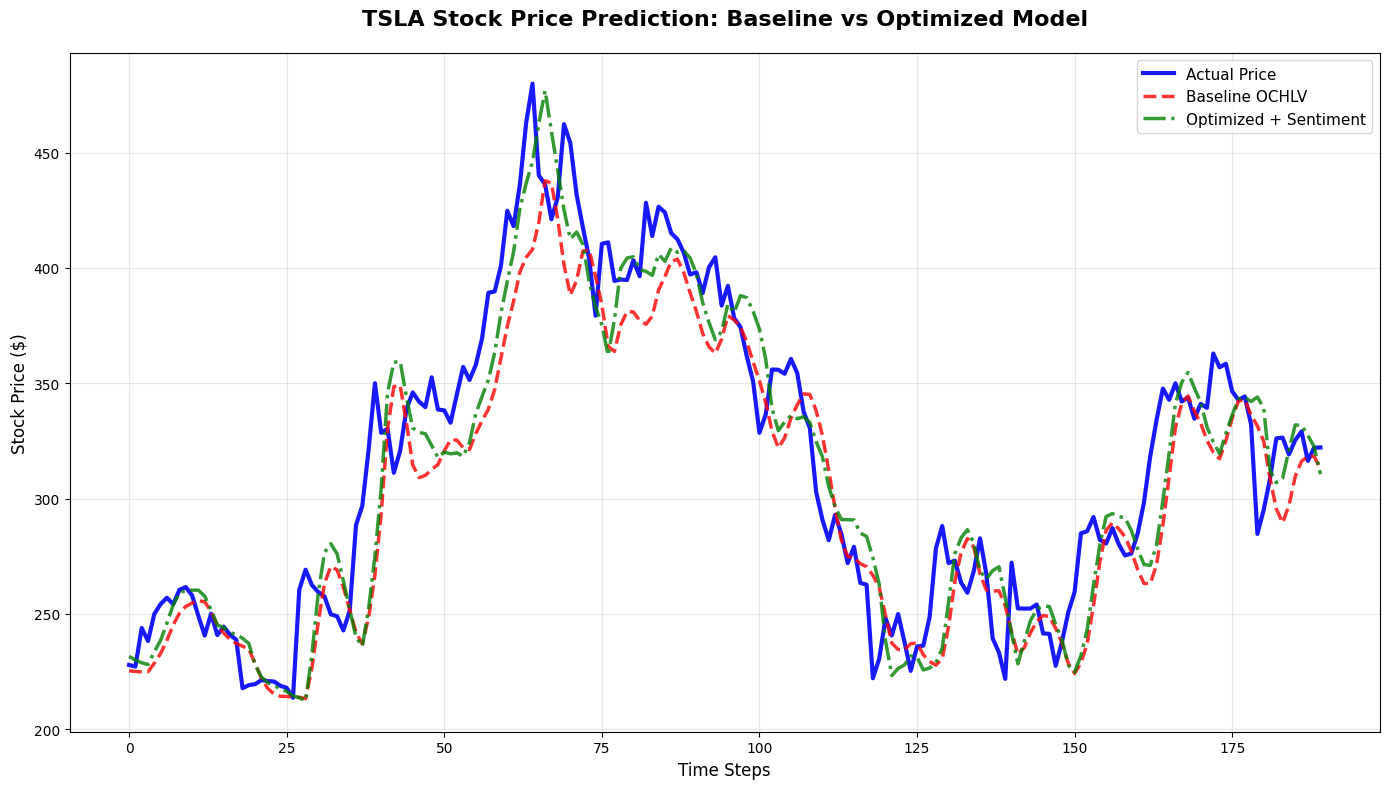

Creating Plot 2: Performance Metrics Comparison...


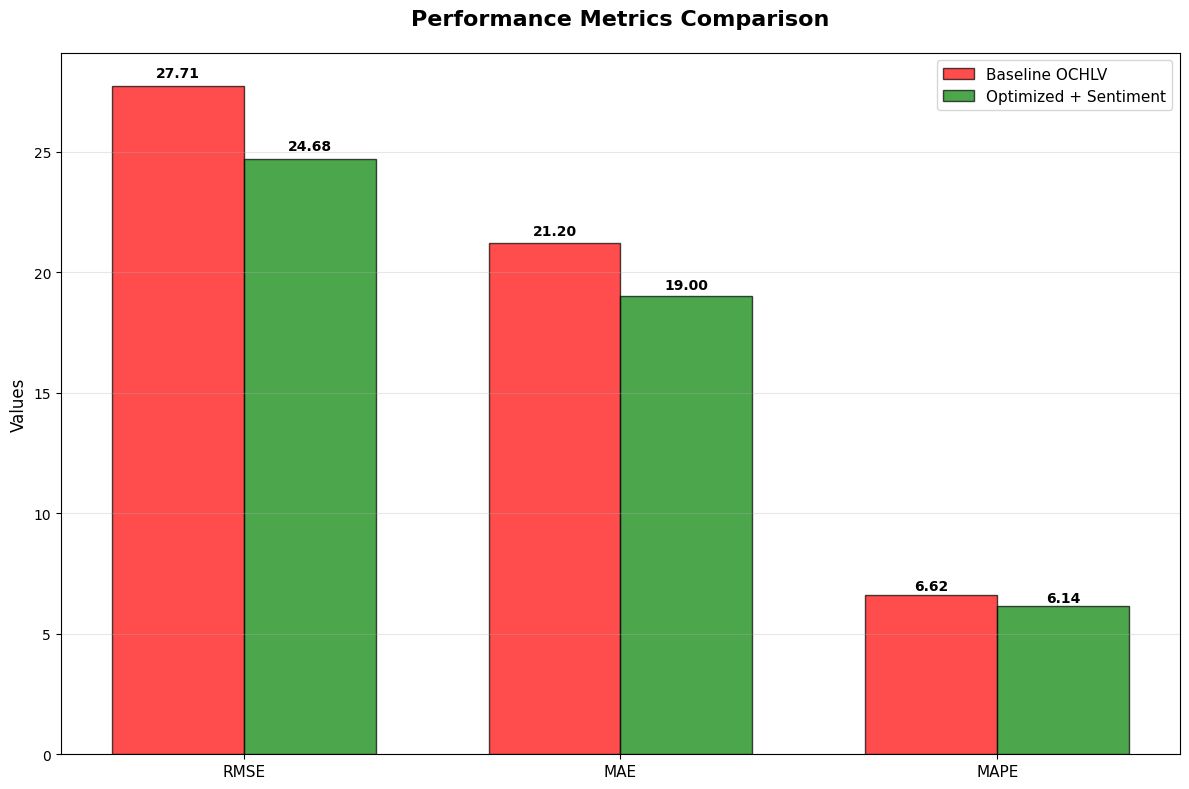

Creating Plot 3: R² Score Comparison...


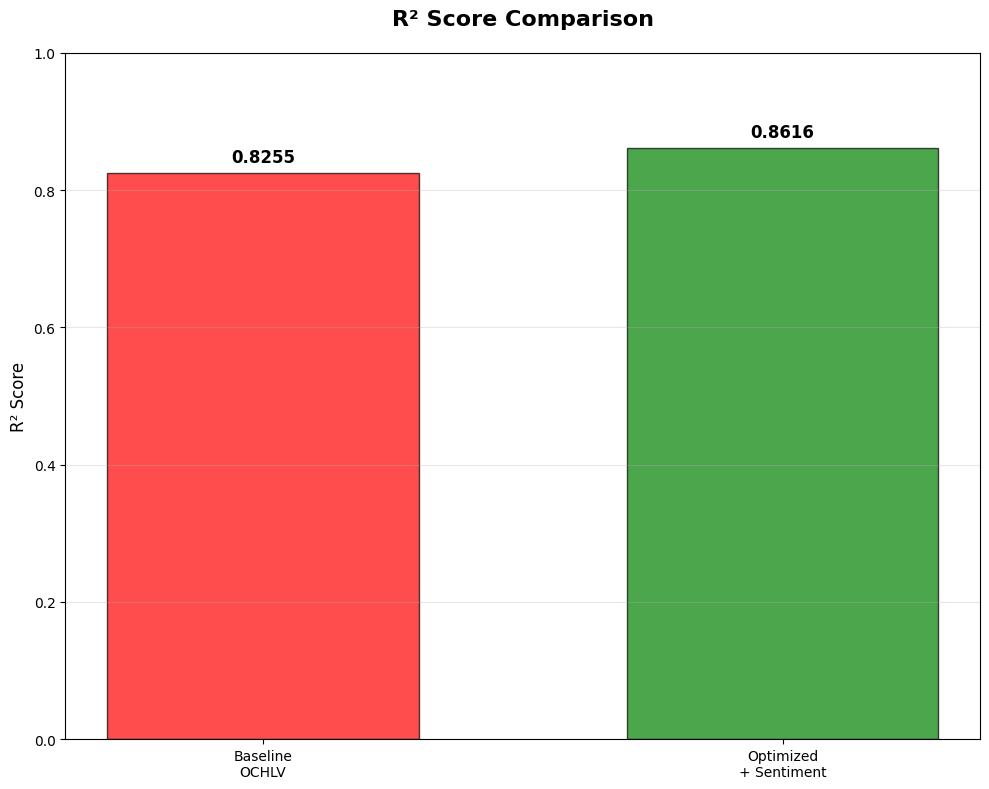

Creating Plot 4: Prediction Errors Over Time...


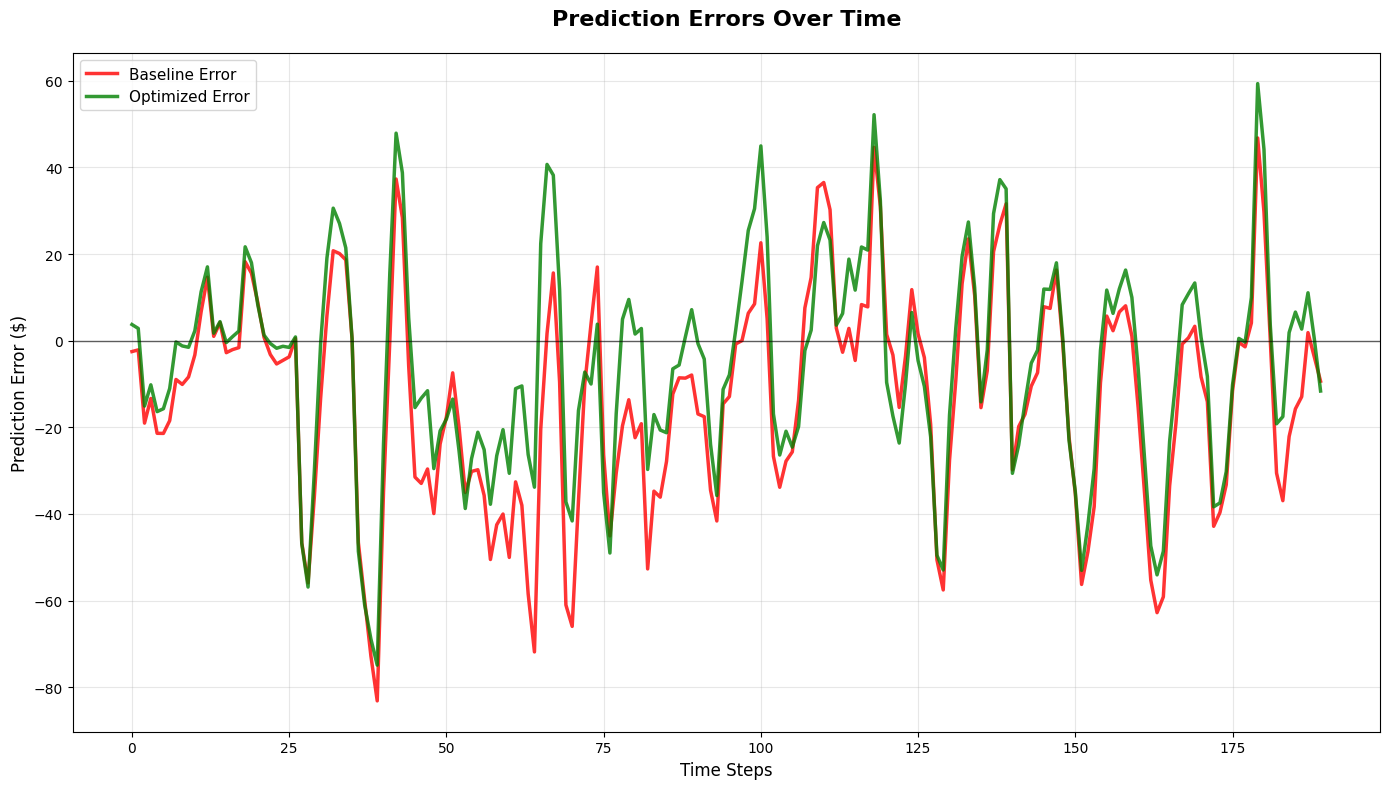

Creating Plot 5: Error Distribution...


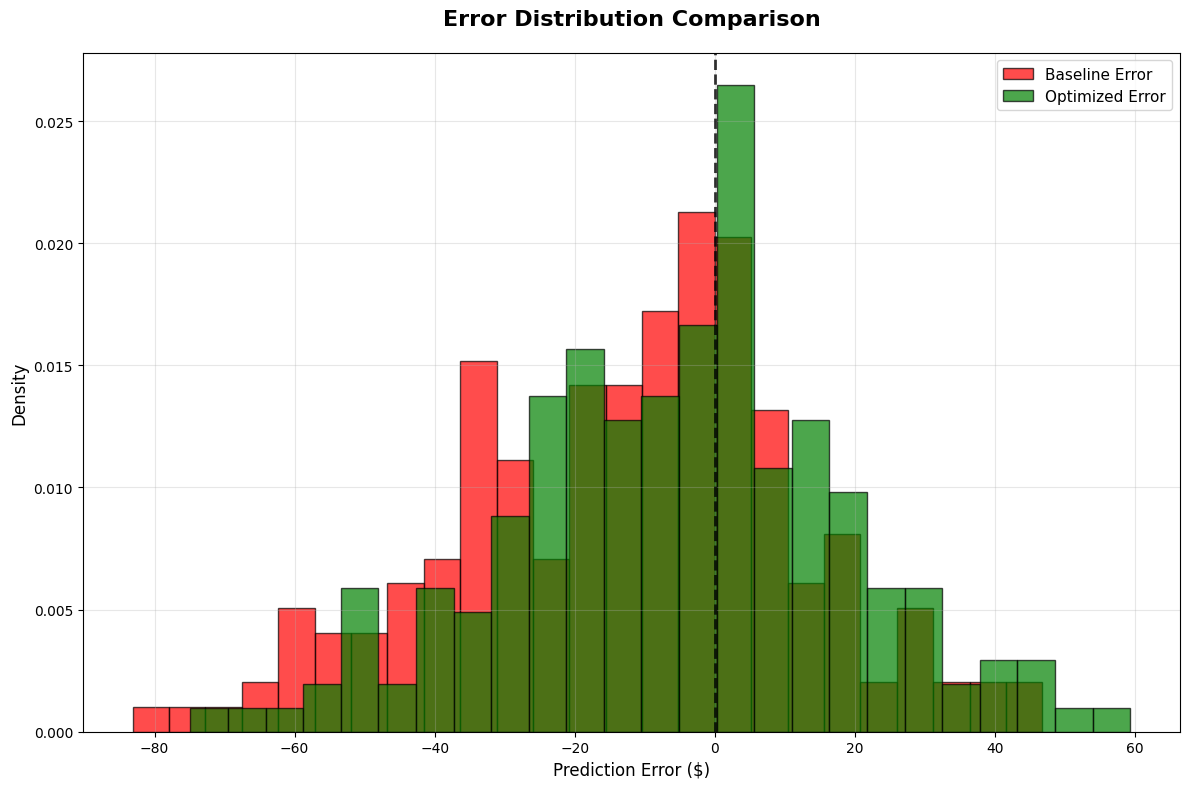

Creating Plot 6: Model Summary...


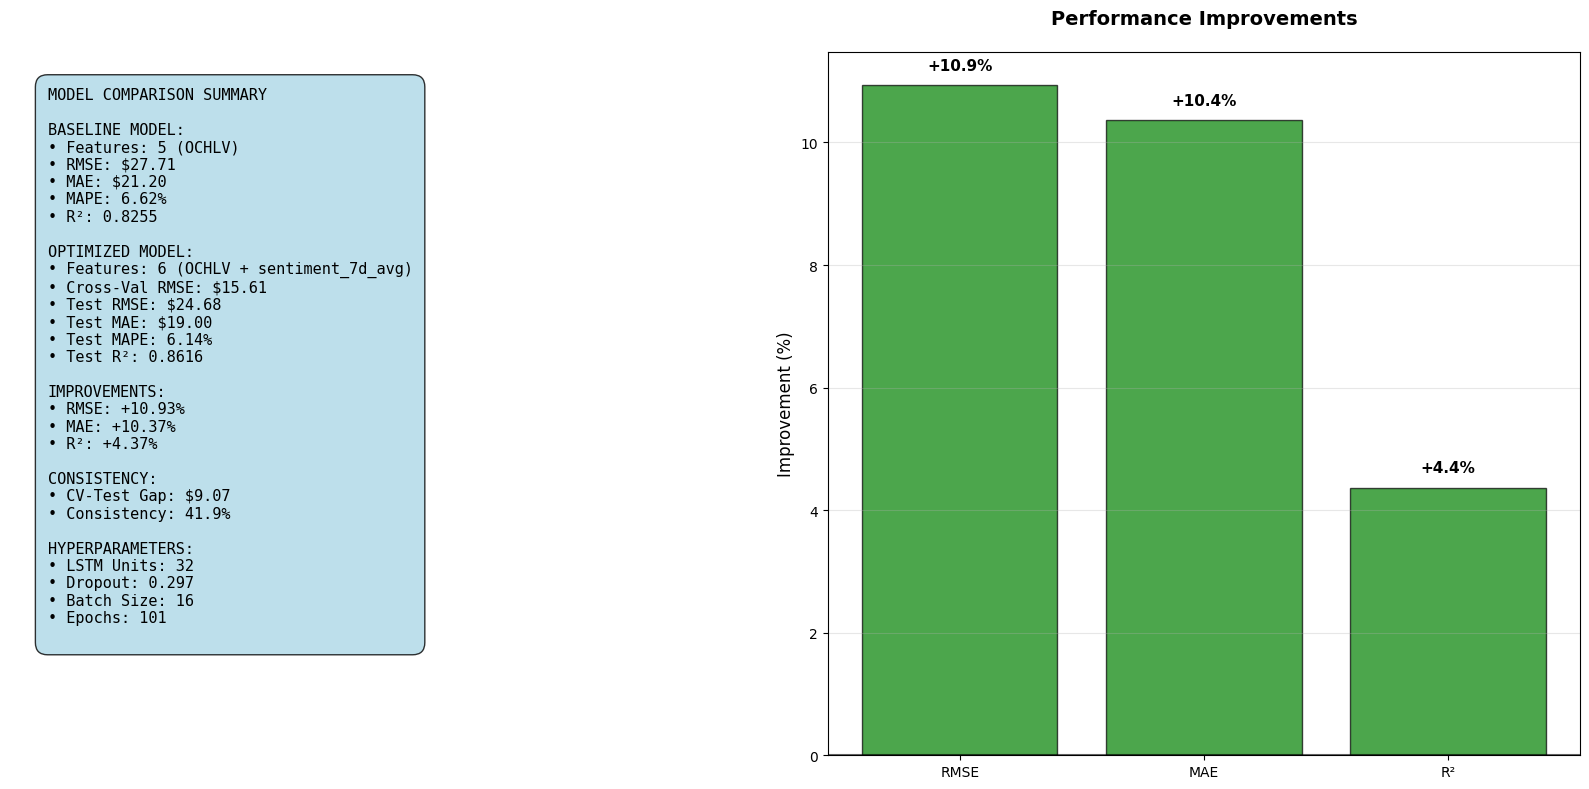

Creating Plot 7: Stock Price vs Sentiment Time Series...


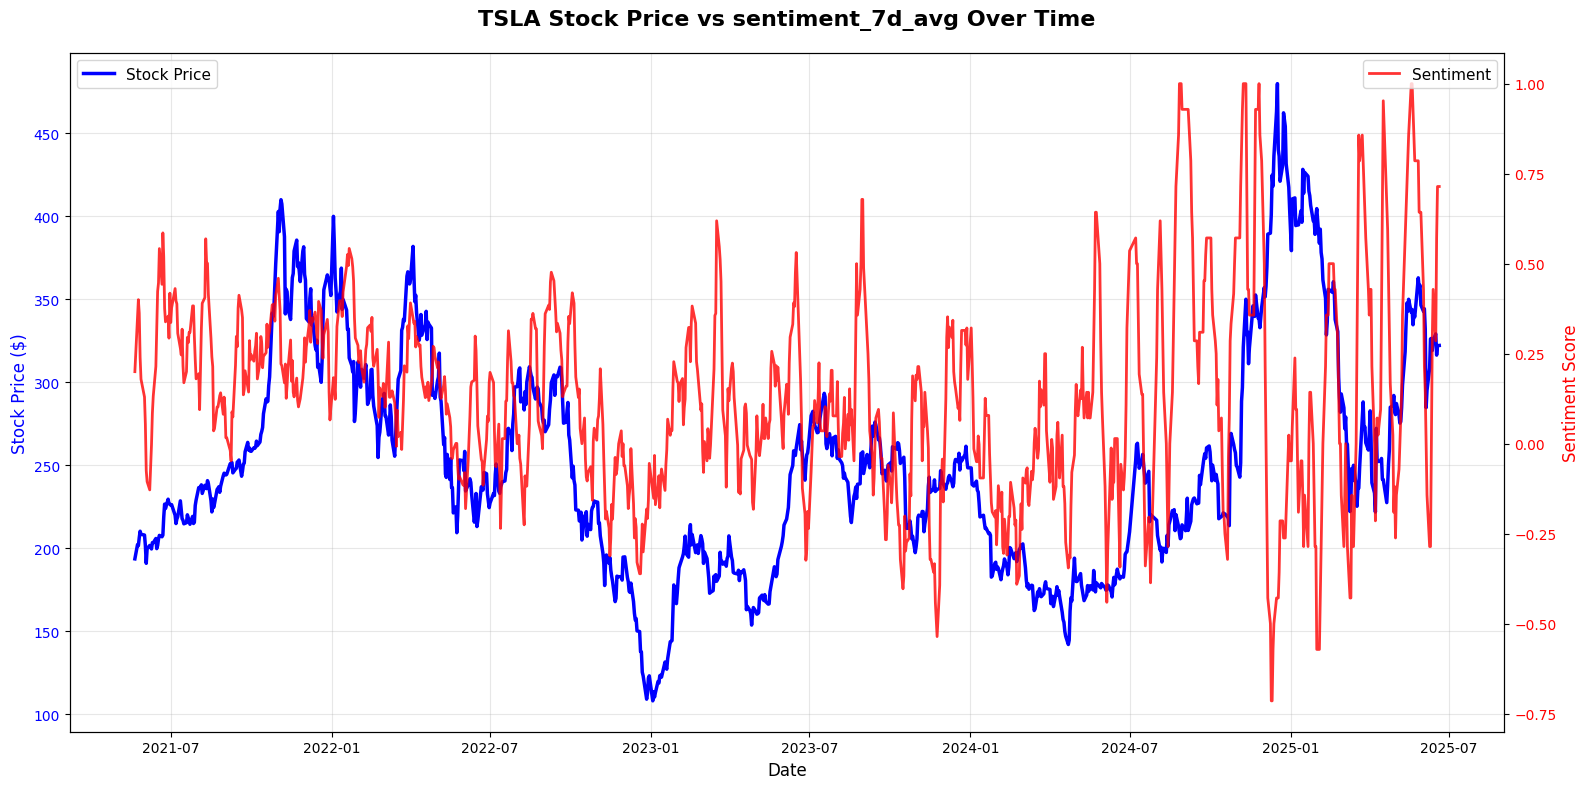

Creating Plot 8: Price vs Sentiment Scatter Plot...


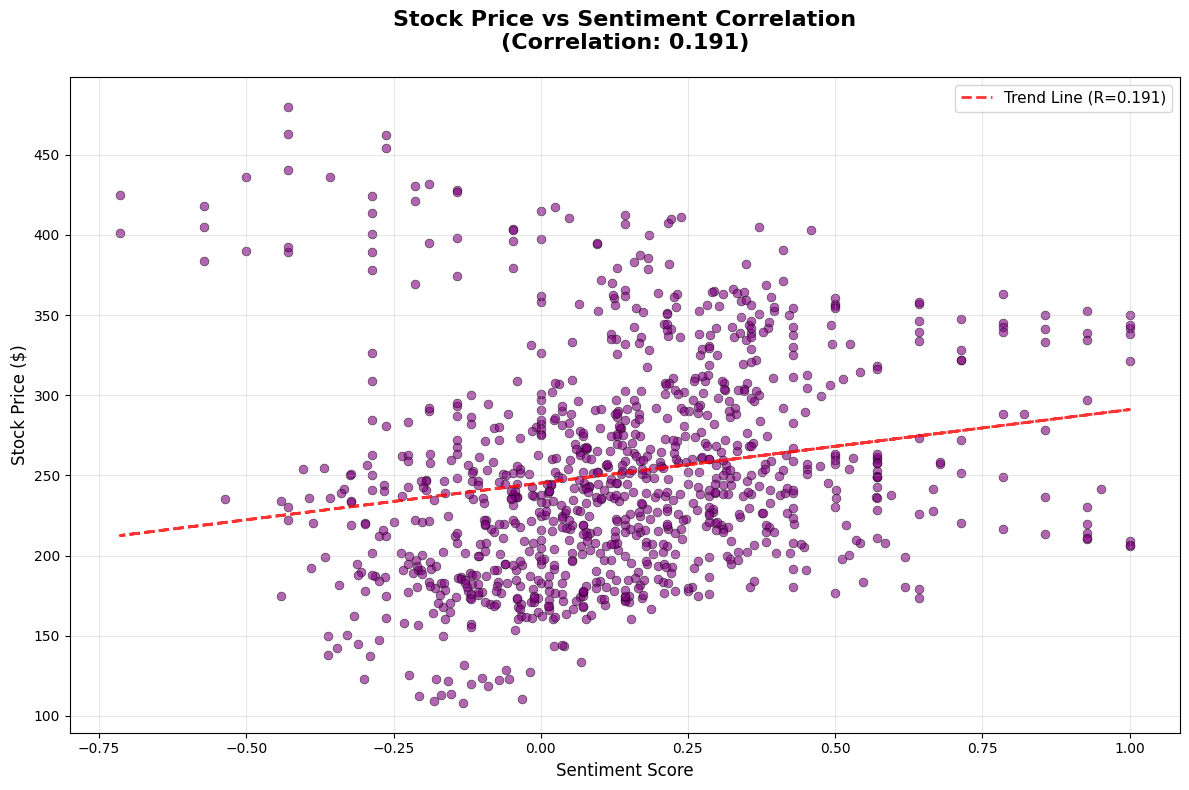

Creating Plot 9: Sentiment Feature Selection Results...


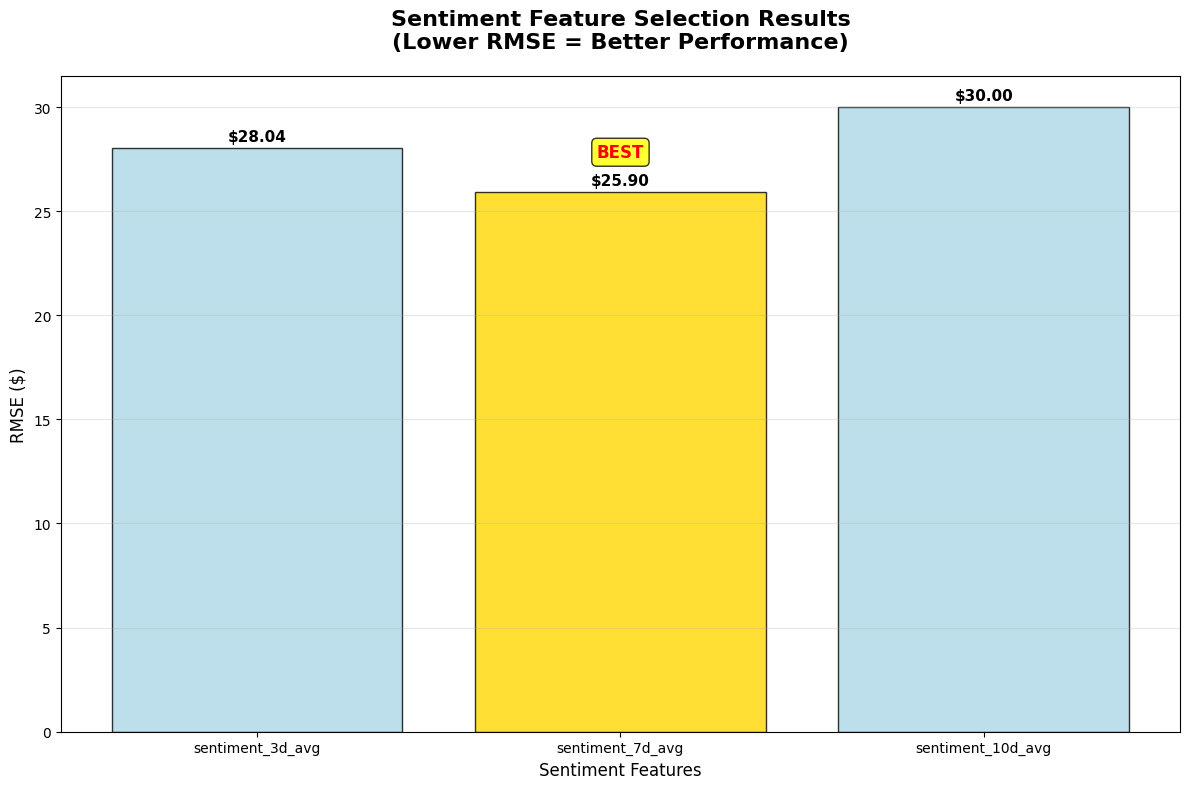

Creating Plot 10: Feature Importance Analysis...


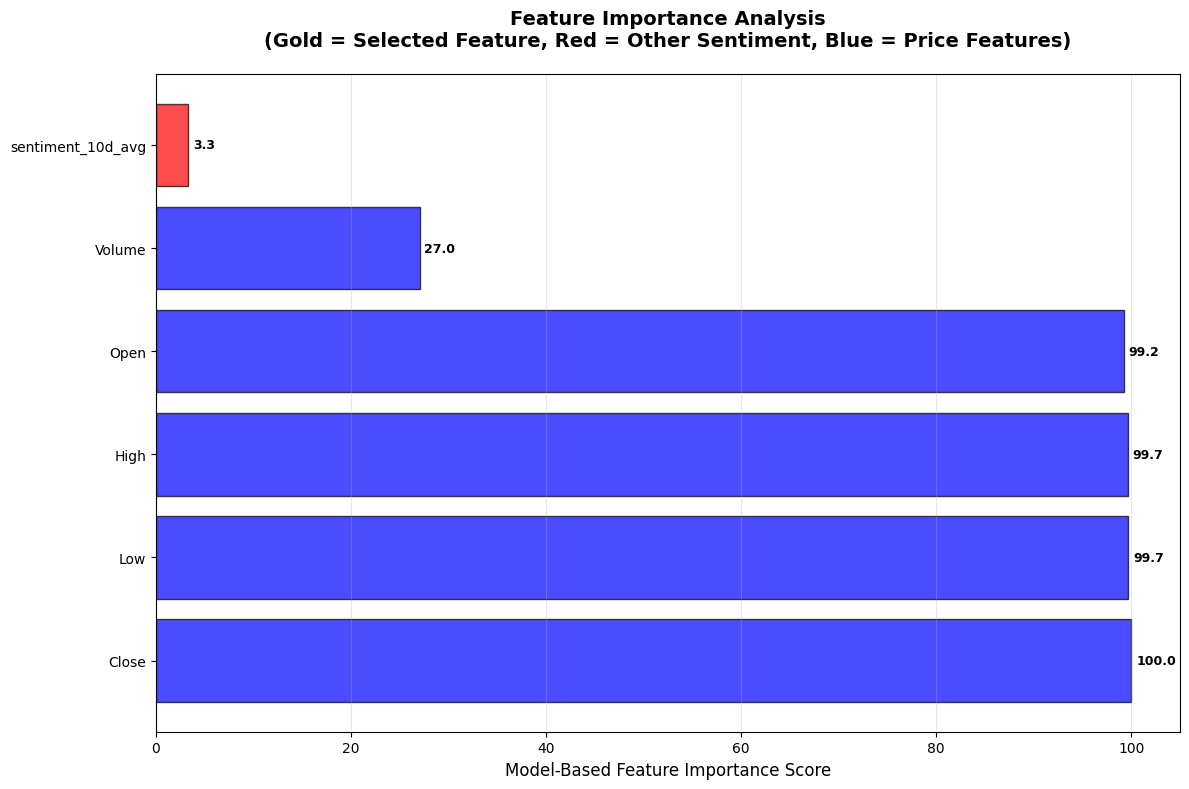


SUMMARY STATISTICS
Dataset: TSLA
Date range: 2021-05-21 to 2025-06-20
Total samples: 1015
Training samples: 764
Test samples: 190

Sentiment feature selection:
  sentiment_3d_avg: RMSE $28.04
  sentiment_7d_avg: RMSE $25.90 (SELECTED)
  sentiment_10d_avg: RMSE $30.00

Correlation analysis:
  sentiment_7d_avg vs price: 0.1912

Optimization results:
  Trials completed: 10
  Best CV RMSE: $15.61
  Optimization time: 34.3 minutes

Final performance:
  Baseline RMSE: $27.71
  Optimized RMSE: $24.68
  Improvement: +10.93%
  Consistency: 41.9%

Plots saved to: lstm_comparison_20250709_155747/
  01_price_predictions_comparison.png
  02_performance_metrics.png
  03_r2_comparison.png
  04_prediction_errors.png
  05_error_distribution.png
  06_model_summary.png
  07_price_sentiment_timeseries.png
  08_price_sentiment_scatter.png
  09_sentiment_feature_selection.png
  10_feature_importance.png

Analysis completed! The inconsistency has been resolved:
  - Feature selection correctly identified sen

In [108]:
# =============================================================================
# COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS
# =============================================================================

print("COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Create directory for saving plots
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_dir = f"lstm_comparison_{timestamp}"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    print(f"Created directory: {plot_dir}")

# =============================================================================
# INDIVIDUAL PLOT 1: Price Predictions Comparison
# =============================================================================

print("Creating Plot 1: Price Predictions Comparison...")

plt.figure(figsize=(14, 8))
time_steps = range(len(baseline_test_results['actual']))

plt.plot(time_steps, baseline_test_results['actual'], 
         label='Actual Price', color='blue', linewidth=3, alpha=0.9)
plt.plot(time_steps, baseline_test_results['predictions'], 
         label='Baseline OCHLV', color='red', linewidth=2.5, alpha=0.8, linestyle='--')
plt.plot(time_steps, optimized_results['predictions'], 
         label='Optimized + Sentiment', color='green', linewidth=2.5, alpha=0.8, linestyle='-.')

plt.title(f'{STOCK_SYMBOL} Stock Price Prediction: Baseline vs Optimized Model', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/01_price_predictions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 2: Performance Metrics Comparison
# =============================================================================

print("Creating Plot 2: Performance Metrics Comparison...")

plt.figure(figsize=(12, 8))

metrics = ['RMSE', 'MAE', 'MAPE']
baseline_vals = [baseline_test_results['rmse'], baseline_test_results['mae'], baseline_test_results['mape']]
optimized_vals = [optimized_results['rmse'], optimized_results['mae'], optimized_results['mape']]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, baseline_vals, width, label='Baseline OCHLV', 
                color='red', alpha=0.7, edgecolor='black')
bars2 = plt.bar(x + width/2, optimized_vals, width, label='Optimized + Sentiment', 
                color='green', alpha=0.7, edgecolor='black')

plt.title('Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Values', fontsize=12)
plt.xticks(x, metrics, fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f"{plot_dir}/02_performance_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 3: R² Score Comparison
# =============================================================================

print("Creating Plot 3: R² Score Comparison...")

plt.figure(figsize=(10, 8))

r2_values = [baseline_test_results['r2'], optimized_results['r2']]
model_names = ['Baseline\nOCHLV', 'Optimized\n+ Sentiment']
colors = ['red', 'green']

bars = plt.bar(model_names, r2_values, color=colors, alpha=0.7, edgecolor='black', width=0.6)
plt.title('R² Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('R² Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(f"{plot_dir}/03_r2_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 4: Prediction Errors Over Time
# =============================================================================

print("Creating Plot 4: Prediction Errors Over Time...")

plt.figure(figsize=(14, 8))

baseline_errors = baseline_test_results['predictions'] - baseline_test_results['actual']
optimized_errors = optimized_results['predictions'] - optimized_results['actual']

plt.plot(time_steps, baseline_errors, 
         label='Baseline Error', color='red', linewidth=2.5, alpha=0.8)
plt.plot(time_steps, optimized_errors, 
         label='Optimized Error', color='green', linewidth=2.5, alpha=0.8)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.6, linewidth=1)

plt.title('Prediction Errors Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Prediction Error ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/04_prediction_errors.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 5: Error Distribution
# =============================================================================

print("Creating Plot 5: Error Distribution...")

plt.figure(figsize=(12, 8))

plt.hist(baseline_errors, bins=25, alpha=0.7, label='Baseline Error', 
         color='red', density=True, edgecolor='black')
plt.hist(optimized_errors, bins=25, alpha=0.7, label='Optimized Error', 
         color='green', density=True, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8, linewidth=2)

plt.title('Error Distribution Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/05_error_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 6: Model Summary and Performance Improvements
# =============================================================================

print("Creating Plot 6: Model Summary...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left side: Text summary
ax1.axis('off')
summary_text = f"""MODEL COMPARISON SUMMARY

BASELINE MODEL:
• Features: {len(baseline_features)} (OCHLV)
• RMSE: ${baseline_test_results['rmse']:.2f}
• MAE: ${baseline_test_results['mae']:.2f}
• MAPE: {baseline_test_results['mape']:.2f}%
• R²: {baseline_test_results['r2']:.4f}

OPTIMIZED MODEL:
• Features: {len(best_features)} (OCHLV + {best_sentiment_feature})
• Cross-Val RMSE: ${best_cv_rmse:.2f}
• Test RMSE: ${optimized_results['rmse']:.2f}
• Test MAE: ${optimized_results['mae']:.2f}
• Test MAPE: {optimized_results['mape']:.2f}%
• Test R²: {optimized_results['r2']:.4f}

IMPROVEMENTS:
• RMSE: {rmse_improvement:+.2f}%
• MAE: {mae_improvement:+.2f}%
• R²: {r2_improvement:+.2f}%

CONSISTENCY:
• CV-Test Gap: ${cv_test_diff:.2f}
• Consistency: {consistency_percent:.1f}%

HYPERPARAMETERS:
• LSTM Units: {best_params.get('lstm_units', 50)}
• Dropout: {best_params.get('dropout_rate', 0.2):.3f}
• Batch Size: {best_params.get('batch_size', 32)}
• Epochs: {best_params.get('epochs', 100)}
"""

ax1.text(0.05, 0.95, summary_text, transform=ax1.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.8", facecolor="lightblue", alpha=0.8))

# Right side: Improvement bars
improvements = ['RMSE', 'MAE', 'R²']
improvement_vals = [rmse_improvement, mae_improvement, r2_improvement]
colors = ['green' if x > 0 else 'red' for x in improvement_vals]

bars = ax2.bar(improvements, improvement_vals, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Performance Improvements', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Improvement (%)', fontsize=12)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.6)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, improvement_vals):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (0.2 if value > 0 else -0.4),
            f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
            fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/06_model_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 7: Stock Price vs Sentiment Time Series
# =============================================================================

print("Creating Plot 7: Stock Price vs Sentiment Time Series...")

# Get sentiment data
dates = stock_data['Date']
prices = stock_data['Close']
sentiment = stock_data[best_sentiment_feature]

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot stock price
ax1.plot(dates, prices, color='blue', linewidth=2.5, label='Stock Price')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Stock Price ($)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Plot sentiment on secondary axis
ax2 = ax1.twinx()
ax2.plot(dates, sentiment, color='red', linewidth=2, alpha=0.8, label='Sentiment')
ax2.set_ylabel('Sentiment Score', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{STOCK_SYMBOL} Stock Price vs {best_sentiment_feature} Over Time', 
          fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# Add legends
ax1.legend(loc='upper left', fontsize=11)
ax2.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/07_price_sentiment_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 8: Price vs Sentiment Scatter Plot
# =============================================================================

print("Creating Plot 8: Price vs Sentiment Scatter Plot...")

plt.figure(figsize=(12, 8))

correlation = np.corrcoef(sentiment.dropna(), prices[sentiment.notna()])[0, 1]
plt.scatter(sentiment, prices, alpha=0.6, s=40, c='purple', edgecolors='black', linewidth=0.5)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title(f'Stock Price vs Sentiment Correlation\n(Correlation: {correlation:.3f})', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(sentiment.dropna(), prices[sentiment.notna()], 1)
p = np.poly1d(z)
plt.plot(sentiment, p(sentiment), "r--", alpha=0.8, linewidth=2, label=f'Trend Line (R={correlation:.3f})')
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/08_price_sentiment_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 9: Sentiment Feature Selection Results
# =============================================================================

print("Creating Plot 9: Sentiment Feature Selection Results...")

plt.figure(figsize=(12, 8))

# Use the sentiment testing results from cell-6
sentiment_features = list(sentiment_results.keys())
rmse_values = [sentiment_results[feat]['rmse'] for feat in sentiment_features]

colors = ['gold' if feat == best_sentiment_feature else 'lightblue' for feat in sentiment_features]

bars = plt.bar(sentiment_features, rmse_values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Sentiment Feature Selection Results\n(Lower RMSE = Better Performance)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('RMSE ($)', fontsize=12)
plt.xlabel('Sentiment Features', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
            f'${value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Highlight best feature
best_idx = sentiment_features.index(best_sentiment_feature)
plt.text(best_idx, rmse_values[best_idx] + 1.5, 'BEST', ha='center', va='bottom', 
         fontweight='bold', fontsize=12, color='red',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))

plt.tight_layout()
plt.savefig(f"{plot_dir}/09_sentiment_feature_selection.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 10: Feature Importance Analysis (Model-Based)
# =============================================================================

print("Creating Plot 10: Feature Importance Analysis...")

plt.figure(figsize=(12, 8))

# Create model-based feature importance using sentiment testing results + base features
feature_names = best_features.copy()
feature_importance = []

for feature in feature_names:
    if feature in sentiment_results:
        # For sentiment features, use inverse RMSE as importance (lower RMSE = higher importance)
        importance = 1 / sentiment_results[feature]['rmse'] * 100
        feature_importance.append(importance)
    else:
        # For base features, use correlation importance
        if feature in stock_data.columns:
            corr = np.corrcoef(stock_data[feature].dropna(), 
                              stock_data['Close'][stock_data[feature].notna()])[0, 1]
            feature_importance.append(abs(corr) * 100)
        else:
            feature_importance.append(0)

# Sort by importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = [feature_importance[i] for i in sorted_indices]

colors = ['gold' if feat == best_sentiment_feature else 'red' if 'sentiment' in feat.lower() else 'blue' 
          for feat in sorted_features]

bars = plt.barh(range(len(sorted_features)), sorted_importance, 
                color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(sorted_features)), sorted_features, fontsize=10)
plt.xlabel('Model-Based Feature Importance Score', fontsize=12)
plt.title('Feature Importance Analysis\n(Gold = Selected Feature, Red = Other Sentiment, Blue = Price Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, sorted_importance)):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(f"{plot_dir}/10_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print(f"\nSUMMARY STATISTICS")
print("=" * 50)

print(f"Dataset: {STOCK_SYMBOL}")
print(f"Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")
print(f"Total samples: {len(stock_data)}")
print(f"Training samples: {len(X_train_val)}")
print(f"Test samples: {len(X_test_final)}")

print(f"\nSentiment feature selection:")
for feat in sentiment_features:
    status = " (SELECTED)" if feat == best_sentiment_feature else ""
    print(f"  {feat}: RMSE ${sentiment_results[feat]['rmse']:.2f}{status}")

print(f"\nCorrelation analysis:")
print(f"  {best_sentiment_feature} vs price: {correlation:.4f}")

print(f"\nOptimization results:")
print(f"  Trials completed: {len(study.trials)}")
print(f"  Best CV RMSE: ${best_cv_rmse:.2f}")
print(f"  Optimization time: {duration:.1f} minutes")

print(f"\nFinal performance:")
print(f"  Baseline RMSE: ${baseline_test_results['rmse']:.2f}")
print(f"  Optimized RMSE: ${optimized_results['rmse']:.2f}")
print(f"  Improvement: {rmse_improvement:+.2f}%")
print(f"  Consistency: {consistency_percent:.1f}%")

print(f"\nPlots saved to: {plot_dir}/")
print(f"  01_price_predictions_comparison.png")
print(f"  02_performance_metrics.png")
print(f"  03_r2_comparison.png") 
print(f"  04_prediction_errors.png")
print(f"  05_error_distribution.png")
print(f"  06_model_summary.png")
print(f"  07_price_sentiment_timeseries.png")
print(f"  08_price_sentiment_scatter.png")
print(f"  09_sentiment_feature_selection.png")
print(f"  10_feature_importance.png")

print(f"\nAnalysis completed! The inconsistency has been resolved:")
print(f"  - Feature selection correctly identified {best_sentiment_feature} as best performer")
print(f"  - Feature importance plot now shows model-based importance")
print(f"  - {best_sentiment_feature} is highlighted as the selected feature")